This notebook uses the latest bid data csv from: https://bidarchive.relayscan.io/index.html
Data fields: https://github.com/flashbots/relayscan/blob/main/docs/2024-06_bidcollect.md

In [69]:
from data_prep_utils import *
from plot_prep_utils import *
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import os
import pandas as pd # type: ignore
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Get yesterday's date string
def get_yesterday():
    yesterday = datetime.today() - timedelta(days=1)
    yesterday = yesterday.strftime('%Y-%m-%d')
    return yesterday

# Get latest date's date string
latest_date = get_yesterday()

# Get the latest date's csv file name
df_latest_full_day_bids = pd.read_csv(latest_date + '_all.csv')

# filter out the rows with NaN builder_pubkey
df_latest_full_day_bids_with_builder = df_latest_full_day_bids[df_latest_full_day_bids['builder_pubkey'].isna()==False]

df_latest_full_day_bids_with_builder['slot_t_s'] = df_latest_full_day_bids_with_builder['slot_t_ms']/1000

# get the latest builder info from TLDR
df_builder_from_tldr = get_builder_info_from_latest_TLDR_talk()

# Merge the two dataframes to get the builder labels
inner_merged_df = pd.merge(df_latest_full_day_bids_with_builder, df_builder_from_tldr, on='builder_pubkey', how='left')
inner_merged_df.loc[inner_merged_df['builder_label'].isna()==True, 'builder_label'] = "BIDDING_BUILDER_"+ inner_merged_df['builder_pubkey'].str[:10]
df_latest_full_day_bids_with_builder = inner_merged_df



/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_41901/3914031588.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_latest_full_day_bids_with_builder['slot_t_s'] = df_latest_full_day_bids_with_builder['slot_t_ms']/1000


In [70]:
df_latest_top_bids = pd.read_csv(latest_date + '_top.csv')
print(df_latest_top_bids.shape[0])
print(df_latest_top_bids.head(2))
# filter out the rows with NaN builder_pubkey
df_latest_top_bids_with_builder = df_latest_top_bids[df_latest_top_bids['builder_pubkey'].isna()==False]
print(df_latest_top_bids_with_builder.shape[0])
print(df_latest_top_bids_with_builder['block_number'].nunique())
print(df_latest_top_bids_with_builder['block_number'].min())
min_block = df_latest_top_bids_with_builder['block_number'].min()
df_top_min_block = df_latest_top_bids_with_builder[df_latest_top_bids_with_builder['block_number']==min_block]
print(df_top_min_block.shape[0])
print(df_top_min_block['builder_pubkey'].nunique())
df_full_min_block = df_latest_full_day_bids[df_latest_full_day_bids['block_number']==min_block]
print(df_full_min_block.shape[0])


1386687
   source_type  received_at_ms     timestamp_ms     slot  slot_t_ms  \
0            2   1718668800060 1718668800048.00  9320398    1048.00   
1            2   1718668800159 1718668800147.00  9320398    1147.00   

                value                                         block_hash  \
0  275129397463063662  0x23254e61980efceaca4e8cebdf3aa99e73650b66a5dc...   
1  275135196060793912  0x35c14c94331bfd02b86ca99339ed89d010ad9cfe8a07...   

                                         parent_hash  \
0  0x2cc0879355b60e95d28e4207ca0ec65c77dcba2f511e...   
1  0x2cc0879355b60e95d28e4207ca0ec65c77dcba2f511e...   

                                      builder_pubkey  block_number  \
0  0xb211df498dfd8b1956252efa4caa81c351a4dde4a502...      20114939   
1  0xb211df498dfd8b1956252efa4caa81c351a4dde4a502...      20114939   

                          block_fee_recipient                   relay  \
0  0x95222290dd7278aa3ddd389cc1e1d165cc4bafe5  relay.ultrasound.money   
1  0x95222290dd7278aa3d

In [72]:


# print('bidding - columns - after merge on block number:')
# print(inner_merged_df.columns)
# print('bidding - rows - after merge on block number:')
# print( inner_merged_df.shape[0])
# print('bidding - empty builder label rows - after merge on block number:' )
# print(inner_merged_df['builder_label'].isna().sum())
# print('bidding - TLDR filled builder label counts - after merge on block number:' )
# print(inner_merged_df['builder_label'].nunique())

# inner_merged_df.loc[inner_merged_df['builder_label'].isna()==True, 'builder_label'] = "BIDDING_BUILDER_"+ inner_merged_df['builder_pubkey'].str[:10]

# print('bidding - TLDR filled builder label counts - after merge on block number and fillna:' )
# print(inner_merged_df['builder_label'].nunique())

# print('bidding - empty builder label rows - after merge on block number and fillna:' )
# print(inner_merged_df['builder_label'].isna().sum())

# df_latest_full_day_bids_with_builder = inner_merged_df

all_builders = df_latest_full_day_bids_with_builder['builder_label'].unique()
rows_not_starting_with_bidding = sum(not str(element).startswith('BIDDING') for element in all_builders)





In [36]:
def add_watermark(ax, image_path, zoom=0.2, alpha=0.3, position=(0.5, 0.5)):
    """
    Adds a watermark to a given axis.
    
    Parameters:
    - ax: The matplotlib axis where the watermark will be added.
    - image_path: Path to the image to be used as the watermark.
    - zoom: Scaling factor for the image.
    - alpha: Transparency of the image.
    - position: A tuple specifying the position of the image in axes fraction coordinates (0 to 1).
    """
    # Load the image
    image = mpimg.imread(image_path)
    
    # Create an OffsetImage and set the zoom and alpha
    imagebox = OffsetImage(image, zoom=zoom, alpha=alpha)  
    
    # Create the AnnotationBbox with the desired location
    ab = AnnotationBbox(imagebox, position,
                        xycoords='axes fraction',
                        frameon=False)  
    
    # Add the image to the axis
    ax.add_artist(ab)


min:-12.0; max:11.0


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_41901/1933830242.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[(1.0, 1.1], (1.1, 1.2], (1.2, 1.3], (1.2, 1.3], (1.4, 1.5], ..., (0.8, 0.9], (0.8, 0.9], (0.8, 0.9], (0.8, 0.9], (0.9, 1.0]]
Length: 12376378
Categories (230, interval[float64, right]): [(-12.0, -11.9] < (-11.9, -11.8] < (-11.8, -11.7] < (-11.7, -11.6] ... (10.6, 10.7] < (10.7, 10.8] < (10.8, 10.9] < (10.9, 11.0]]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_latest_full_day_bids_with_builder.loc[:,'slot_t_s_bins'] = pd.cut(
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_41901/1933830242.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[(1.0, 1.1], (1.1, 1.2], (1.2, 1.3], (1.2, 1.3], (1.4, 1.5], ..., (0.8, 0.9], (0.8, 0.9], (0.8, 0.9], (0.8, 0.9], (0.9

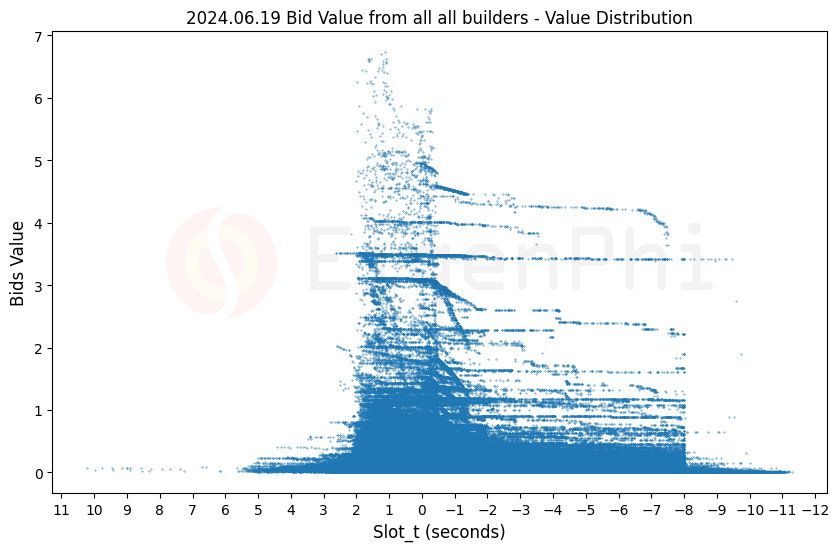

Index(['source_type', 'received_at_ms', 'timestamp_ms', 'slot', 'slot_t_ms',
       'value', 'block_hash', 'parent_hash', 'builder_pubkey', 'block_number',
       'block_fee_recipient', 'relay', 'proposer_pubkey',
       'proposer_fee_recipient', 'optimistic_submission', 'slot_t_s',
       'builder_label', 'slot_t_s_bins', 'value_transformed'],
      dtype='object')
['beaverbuild' 'BIDDING_BUILDER_0xa04b0070' 'BIDDING_BUILDER_0xa03b00dd'
 'BIDDING_BUILDER_0xa01b00a4' 'BIDDING_BUILDER_0xa02b0095' 'Titan'
 'BIDDING_BUILDER_0x946fcf34' 'BIDDING_BUILDER_0xa9d0a0f9'
 'BIDDING_BUILDER_0x8527d16c' 'rsync' 'BIDDING_BUILDER_0xa04a00ea'
 'BIDDING_BUILDER_0xa02a0054' 'BIDDING_BUILDER_0xa03a000b'
 'BIDDING_BUILDER_0xa01a0047' 'BIDDING_BUILDER_0x803a00a9'
 'BIDDING_BUILDER_0x929de7f9' 'Ty For The Block' 'EigenPhi' 'payload'
 'BIDDING_BUILDER_0x803b0018' 'eden' 'Gambit Labs' 'jetbldr' 'BuildAI'
 'BIDDING_BUILDER_0x987dee19' 'bloXroute' 'bobTheBuilder' 'Beelder'
 'tbuilder' 'Manifold' 'lokibuilder' '

/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_41901/1933830242.py:65: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


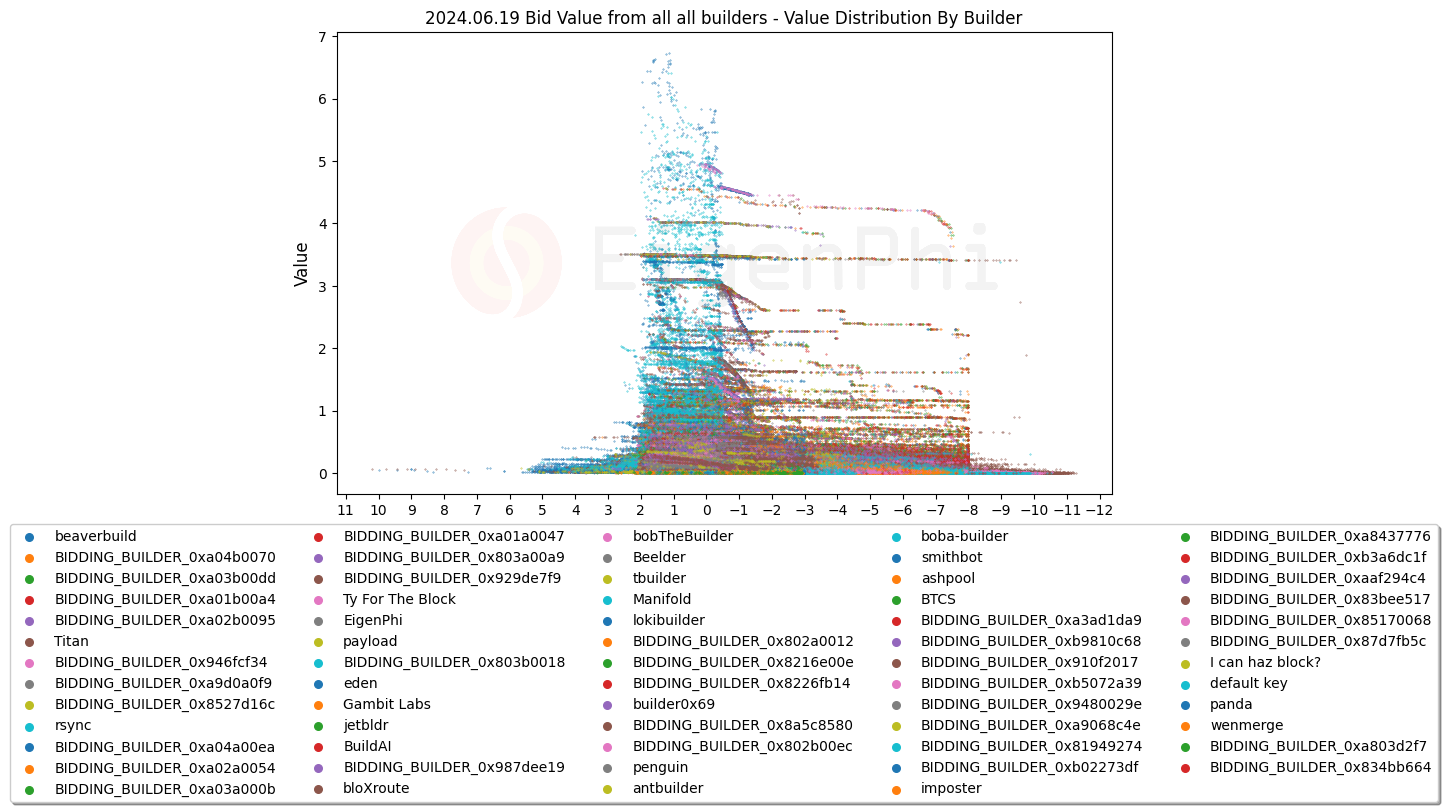

In [40]:
#Now the data is ready. Time to draw.
# Plot the stacked barchart of builder label with ts_diff as the x-axis
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 计算 ts_diff 的最小和最大值
x_min = np.floor(df_latest_full_day_bids_with_builder['slot_t_s'].min())
x_max = np.ceil(df_latest_full_day_bids_with_builder['slot_t_s'].max())
print ("min:" + str(x_min) + "; max:" + str(x_max))


# 创建 `ts_diff_secs` 的区间（每0.1秒）
df_latest_full_day_bids_with_builder.loc[:,'slot_t_s_bins'] = pd.cut(
    df_latest_full_day_bids_with_builder['slot_t_s'], 
    np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
)

df_latest_full_day_bids_with_builder.loc[:,'slot_t_s_bins'] = df_latest_full_day_bids_with_builder['slot_t_s_bins'].apply(lambda interval: pd.Interval(replace_small_values(interval.left), 
                                                                           replace_small_values(interval.right),
                                                                           interval.closed))

df_latest_full_day_bids_with_builder['value_transformed'] = df_latest_full_day_bids_with_builder['value'] / 10 ** 18



# Plot 1: on Overall Bid Value 
fig, ax = plt.subplots(figsize=(10,6))
adjust_plot_x_axis(ax)

# Plot without separating builders
ax.scatter(df_latest_full_day_bids_with_builder['slot_t_s'], df_latest_full_day_bids_with_builder['value_transformed'], s=0.1)

# # # 获取图例并修改点的大小
# # legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
# # for handle in legend.legendHandles:
# #     handle._sizes = [30]

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

plt.xlabel('Slot_t (seconds)', fontsize=12)
plt.ylabel('Bids Value', fontsize=12)
plt.title('2024.06.19 Bid Value from all all builders - Value Distribution')

add_watermark(ax, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

plt.show()
print(df_latest_full_day_bids_with_builder.columns)
print(df_latest_full_day_bids_with_builder['builder_label'].unique())

# Plot 2: on Bid Value by Builder

fig, ax = plt.subplots(figsize=(10,6))
adjust_plot_x_axis(ax)
for label in df_latest_full_day_bids_with_builder['builder_label'].unique():
    dft_label = df_latest_full_day_bids_with_builder[df_latest_full_day_bids_with_builder['builder_label'] == label]
    ax.scatter(dft_label['slot_t_s'], dft_label['value_transformed'], s=0.1, label=label)
    
# 获取图例并修改点的大小
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
for handle in legend.legendHandles:
    handle._sizes = [30]

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

plt.xlabel('slot_t (seconds)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('2024.06.19 Bid Value from all all builders - Value Distribution By Builder')

# Adding watermark using the refactored function
add_watermark(ax, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

plt.show()




# # Chart 2: on Gas Used
# fig, ax2 = plt.subplots(figsize=(10,6))
# adjust_plot_x_axis(ax2)

# # Plot without separating builders
# ax2.scatter(dft_bidding12s['ts_diff_secs'], dft_bidding12s['gas_used'], s=0.1)

# # # 获取图例并修改点的大小
# # legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
# # for handle in legend.legendHandles:
# #     handle._sizes = [30]

# ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Gas Used', fontsize=12)
# plt.title('921 Blocks won by Titan - Bidding data from all all builders - Gas Used Distribution')

# # Adding watermark using the refactored function
# add_watermark(ax2, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

2903715
4194842
928037


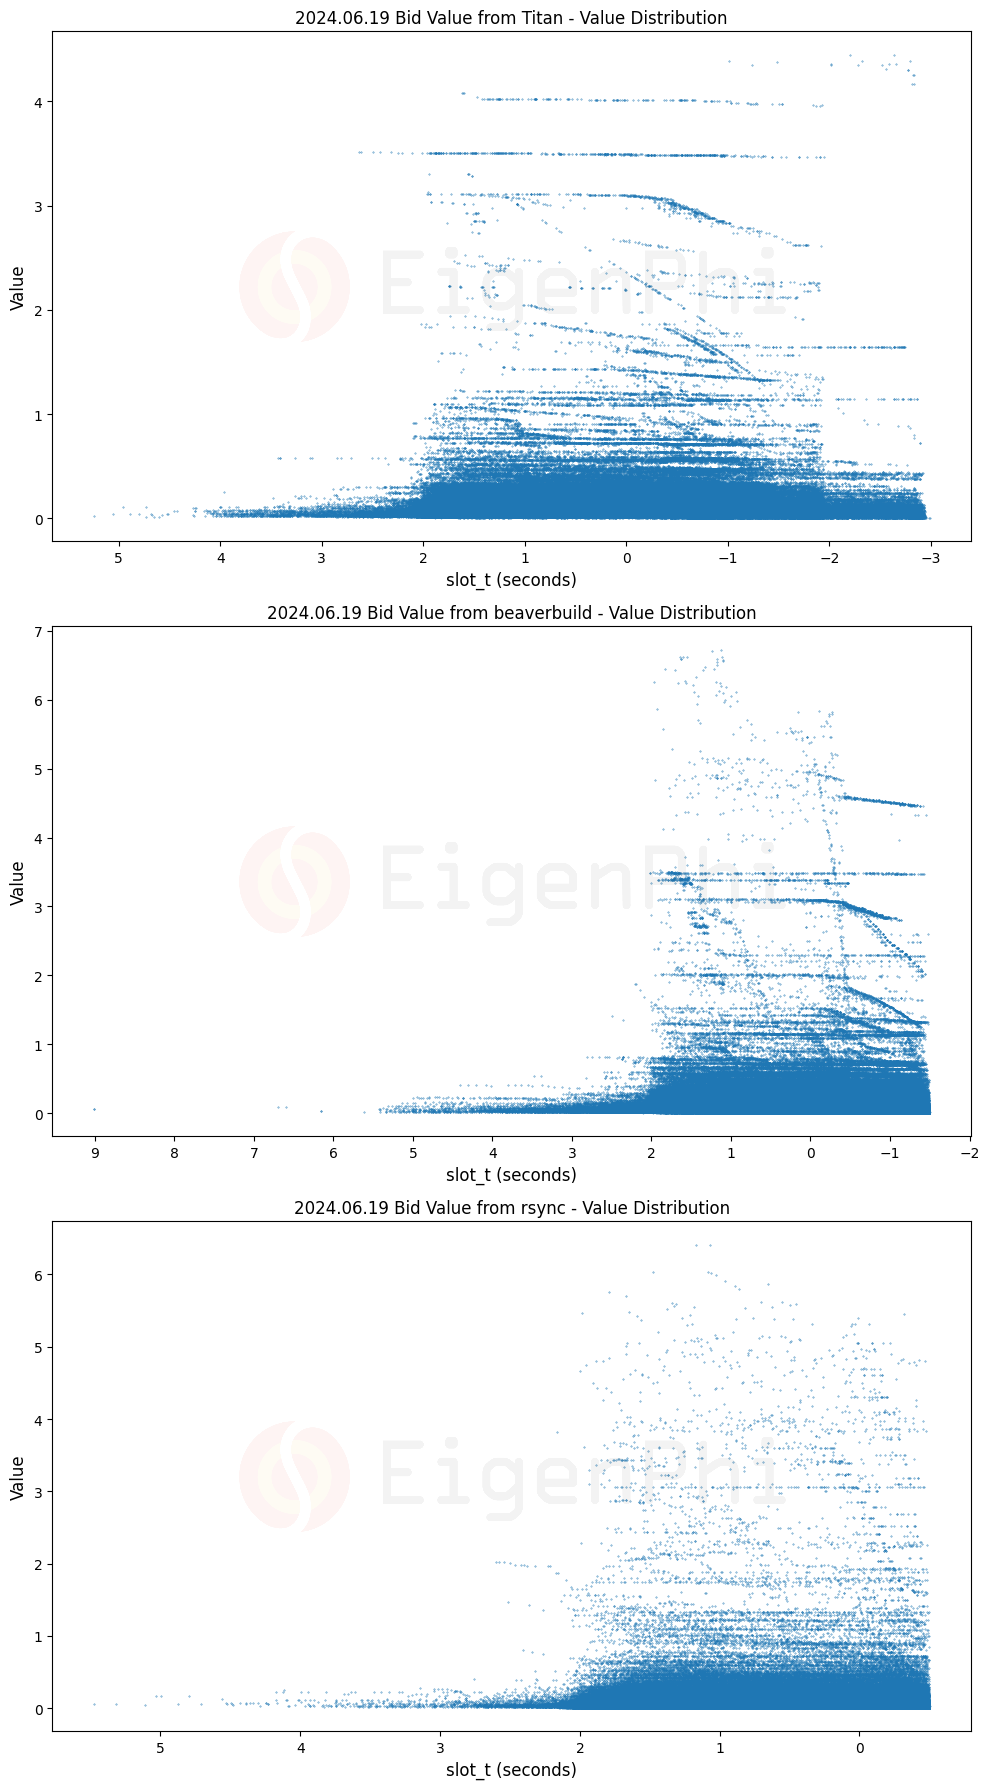

In [43]:

builder_labels = ['Titan', 'beaverbuild', 'rsync']

fig, axs = plt.subplots(3, 1, figsize=(10, 18))  # Set up a subplots grid with 3 rows and 1 column


# Loop over the builder labels and corresponding subplot axes
for ax, label in zip(axs, builder_labels):
    # Filter DataFrame for the current builder label
    dft_label = df_latest_full_day_bids_with_builder[df_latest_full_day_bids_with_builder['builder_label'] == label]
    print(dft_label.shape[0])
    # Plot the data on the current axis
    ax.scatter(dft_label['slot_t_s'], dft_label['value_transformed'], s=0.1, label=label)
    
    # Adjust the x-axis
    adjust_plot_x_axis(ax)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # Set major ticks to every 1 second
    ax.set_xlabel('slot_t (seconds)', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_title(f'2024.06.19 Bid Value from {label} - Value Distribution')

    # Adding watermark
    add_watermark(ax, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

# Adjust layout and show plot
plt.tight_layout()
plt.show()